<a href="https://colab.research.google.com/github/ablet-imin/ml-met-trigger/blob/main/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings 
#warnings.filterwarnings('ignore')
#warnings.filterwarnings('ignore', category=DeprecationWarning)
#from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from IPython.display import display


In [5]:
import h5py
with h5py.File('./data/cells_img50_label.h5', 'r') as h5f:
        images  = np.array(h5f['images'])
        labels = np.array(h5f['labels'])
images = images.reshape(-1, images.shape[1]*images.shape[2])
x_train, x_test, y_train, y_test = train_test_split(images, labels,
                                                test_size=0.2, random_state=42,
                                                shuffle=True
                                                )

In [6]:
#Linear regression
lr_models = {
    #'xgr' : XGBRegressor(),
    #'lgb' : LGBMRegressor(),
    'lr': LinearRegression(),
    #'rfr': RandomForestRegressor(),
    'kr' : KNeighborsRegressor(),
    #'svr': SVR(kernel='linear'),
    'dtr': DecisionTreeRegressor()
}
nModels = len(lr_models.keys())
scores = pd.DataFrame(index=lr_models.keys(),
                      columns=['train', 'test', 'test_r2'],
                      data=np.zeros((nModels,3)) )
met_pred = {}
def fit_to_data():
    for name, lr in lr_models.items():
        lr.fit(x_train, y_train)
        scores['train'][name] = lr.score(x_train,y_train)
        scores['test'][name] = lr.score(x_test,y_test)
        predicted = lr.predict(x_test)
        scores['test_r2'][name] = r2_score(y_test, predicted,)
        #scores['test_RMS'][name] = mean_squared_error(y_test, predicted, squared=False)
        met_pred[name] = predicted
        print(f'{name:10}OK')

In [7]:
fit_to_data()

lr        OK
kr        OK
dtr       OK


In [ ]:
#upload results to wandb
#!pip install wandb

ls: cannot access '/cells_img50_label.h5': No such file or directory


In [8]:
import wandb
wandb.login(key="bbfdeb3824dbf84bd7fc4fa55c5737dab40a8cb7")

wandb: Currently logged in as: ablet. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/abletimin/.netrc


True

In [9]:

run = wandb.init(project="Regression-linear")


In [10]:
wandb.log({
    'scores': scores
})

met_pred['truth']=y_test

wandb.log({
    'prediction': pd.DataFrame(met_pred)
})


In [11]:
xs=scores.index.to_list()
ys=[scores[sk].to_list() for sk in scores.columns.to_list()]

wandb.log({"Score_lines" : wandb.plot.line_series(
          xs=range(len(xs)),
          ys=ys,
          keys=scores.columns.to_list(),
          title="scors",
          xname="x units")})

In [37]:
bins = np.linspace(-100, 400, 51)
for key in met_pred.keys(): 
    _hist = np.histogram(met_pred[key], bins)
    wandb.log({key: wandb.Histogram(np_histogram=_hist)})

## plot Et

In [12]:
#for plot with ATLAS styple
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

import mplhep as hep
#hep.style.use(hep.style.ROOT) # For now ROOT defaults to CMS
# Or choose one of the experiment styles
hep.style.use(hep.style.ATLAS)
plt.style.use(hep.style.ATLAS)

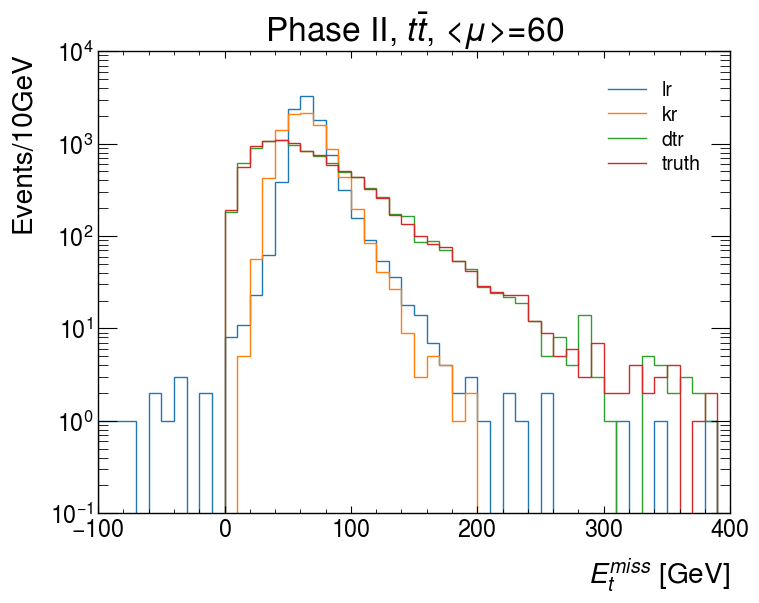

In [49]:
#bin all predicted METs
bins = np.linspace(-100, 400, 51)
fig, axs = plt.subplots()
def get_h(key):
    h, _ = np.histogram(met_pred[key], bins)
    return h
    
hep.histplot([get_h(key) for key in met_pred.keys()],bins,
             ax=axs, label=[key for key in met_pred.keys()] )
axs.legend()
axs.set_xlabel(r"$E_{t}^{miss}$ [GeV]")
axs.set_ylabel(r"Events/10GeV")
axs.set_yscale('log')
axs.set_title(r"Phase II, $t \bar t$, <$\mu$>=60")

wandb.log({"final_plot_log":wandb.Image(plt)})

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x1599b5460>, cbar=<matplotlib.colorbar.Colorbar object at 0x1585e3eb0>, text=[])

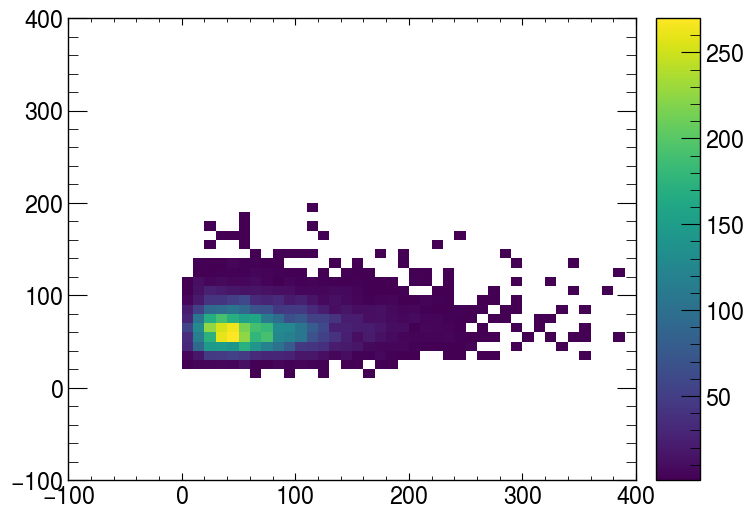

In [58]:
fig2D, axs2D = plt.subplots()
H, xedges, yedges = np.histogram2d(met_pred['truth'], met_pred['kr'], bins=(bins, bins))
H[H==0]=np.NaN
hep.hist2dplot(H, xedges, yedges)


In [57]:
scores

,train,test,test_r2
lr,0.099491,-0.111034,-0.111034
kr,0.282990,-0.094306,-0.094306
dtr,1.000000,-0.842966,-0.842966
